In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import log_loss


### Objective

In this project I plan to compare Resnet and Inception models to see which one is better at learning and classifying the dog breeds in the data set. The models will be trained using pictures of the dogs and then evaluated on a subset of the "training data" that will be labeled as evaluation data. 



### Importing Data and Basic EDA

This code loads the dog breed dataset from a CSV file, appends the file paths of corresponding images, and performs a quick data overview by displaying the dataset's head, shape, column information, and basic statistics. It also verifies if the generated image paths exist in the specified directory.

In [3]:
labels_df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
print(labels_df.head())

image_dir = '/kaggle/input/dog-breed-identification/train/'
labels_df['image_path'] = image_dir + labels_df['id'] + '.jpg'

print("Data Shape")
print(labels_df.shape)
print("Data Overview:")
print(labels_df.info())
print(labels_df.describe())


#verifying paths:
print(all(os.path.exists(path) for path in labels_df['image_path'].head()))


                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
Data Shape
(10222, 3)
Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          10222 non-null  object
 1   breed       10222 non-null  object
 2   image_path  10222 non-null  object
dtypes: object(3)
memory usage: 239.7+ KB
None
                                      id               breed  \
count                              10222               10222   
unique                             10222                 120   
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound   
freq                        

### EDA

This code filters the dataset to include only the top 20 most frequent dog breeds, provides an overview of the filtered data, checks for missing values, and displays six random images with their corresponding breeds. It then plots the distribution of the top 20 breeds and the dimensions of the images (width and height). Finally, it calculates the unique breed count in the filtered dataset and extracts image sizes for further analysis.

Filtered dataset shape: (2184, 3)
Remaining breeds: ['basenji' 'scottish_deerhound' 'maltese_dog' 'cairn' 'tibetan_terrier'
 'shih-tzu' 'australian_terrier' 'samoyed' 'entlebucher' 'airedale'
 'leonberg' 'bernese_mountain_dog' 'afghan_hound' 'miniature_pinscher'
 'irish_wolfhound' 'great_pyrenees' 'beagle' 'japanese_spaniel'
 'pomeranian' 'blenheim_spaniel']

Data Overview after filtering:
<class 'pandas.core.frame.DataFrame'>
Index: 2184 entries, 8 to 10220
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2184 non-null   object
 1   breed       2184 non-null   object
 2   image_path  2184 non-null   object
dtypes: object(3)
memory usage: 68.2+ KB
None
                                      id               breed  \
count                               2184                2184   
unique                              2184                  20   
top     003df8b8a8b05244b1d920bb6cf451f9  scottish_deerhound   
fre

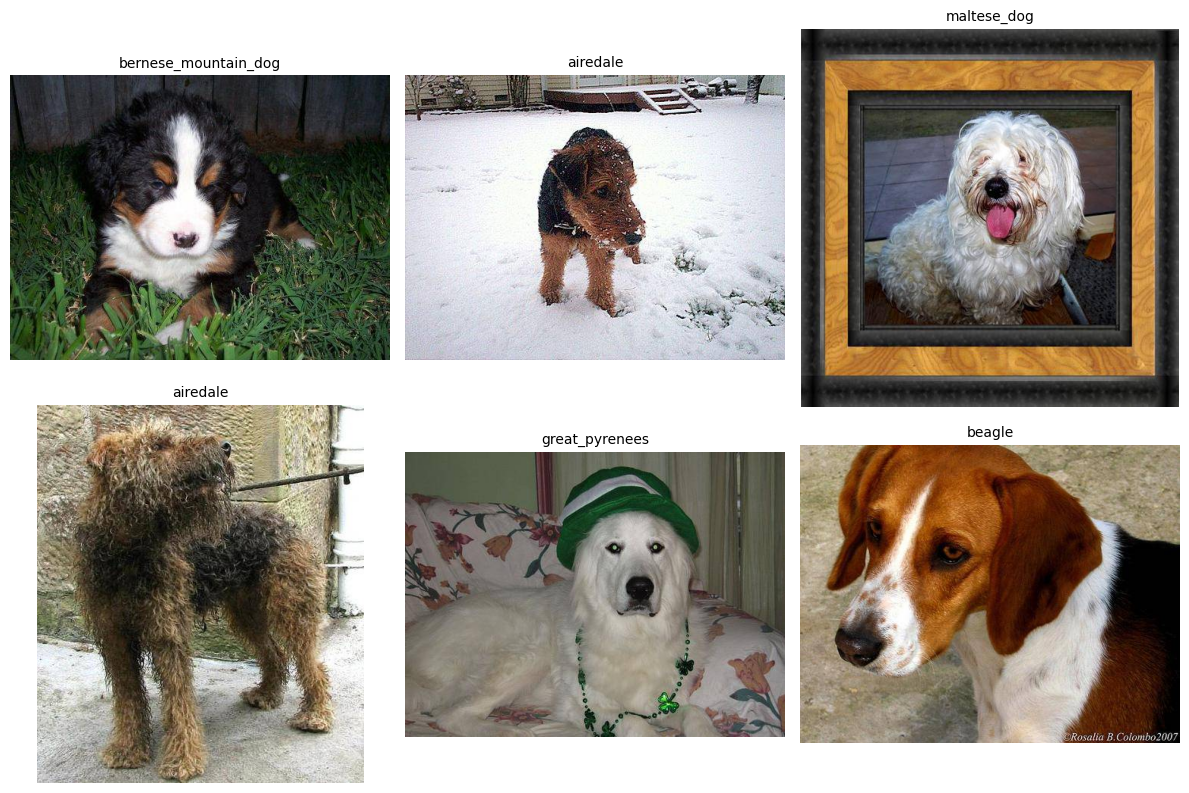

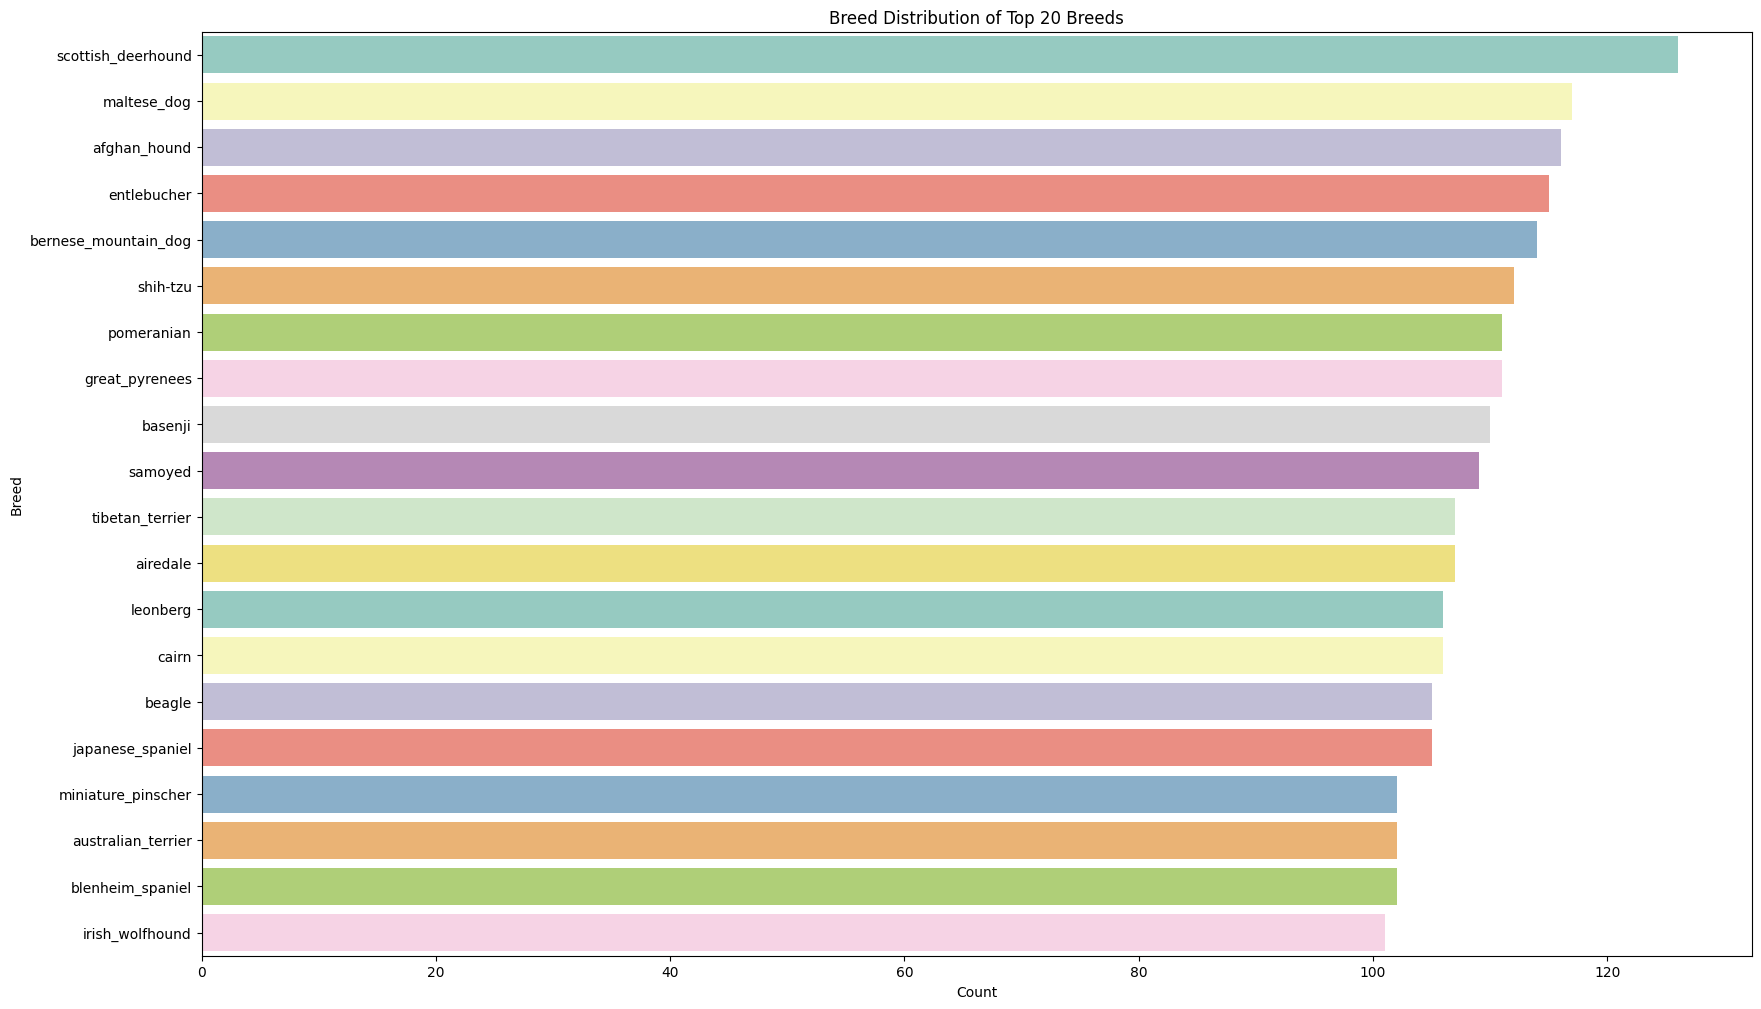

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


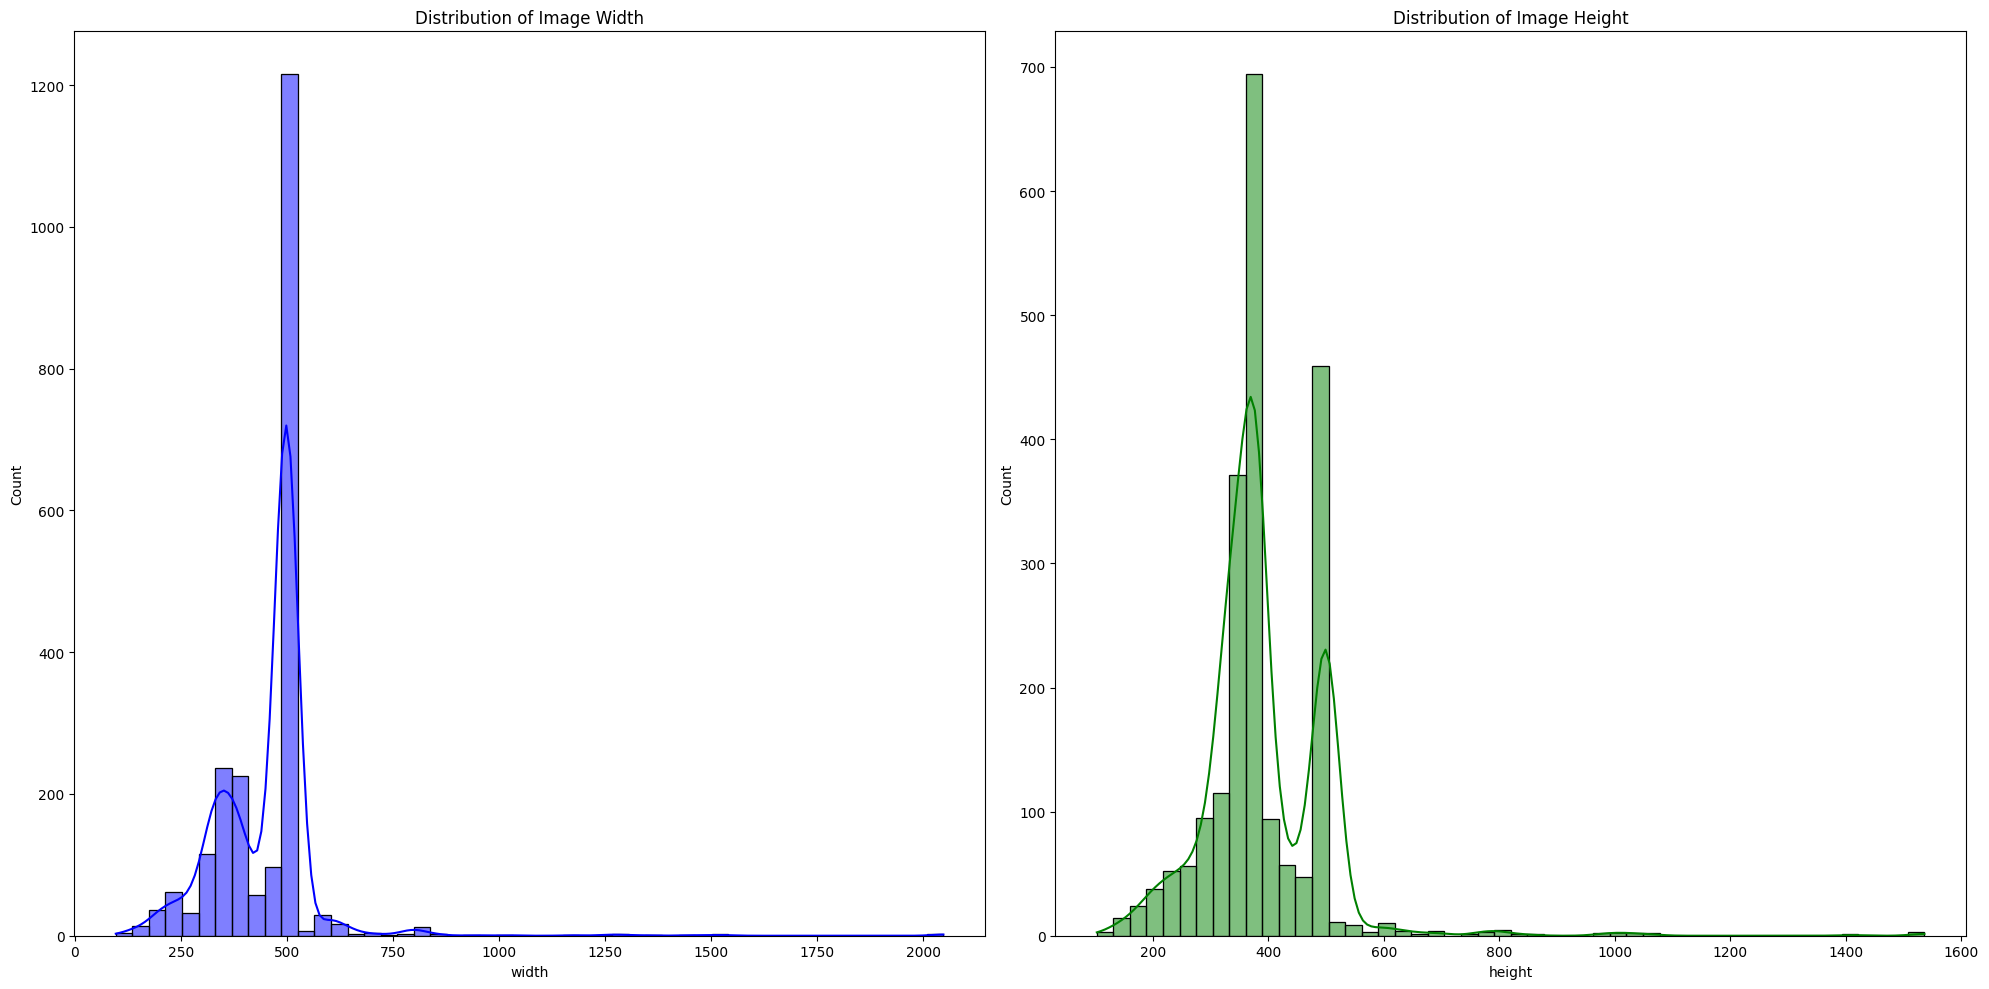


Unique Breeds Count:
Total unique breeds in the filtered dataset: 20


In [4]:
breed_counts = labels_df['breed'].value_counts()

breed_counts = labels_df['breed'].value_counts()

top_20_breeds = breed_counts.head(20).index

labels_df = labels_df[labels_df['breed'].isin(top_20_breeds)]

print(f"Filtered dataset shape: {labels_df.shape}")
print(f"Remaining breeds: {labels_df['breed'].unique()}")

print("\nData Overview after filtering:")
print(labels_df.info())
print(labels_df.describe())

print("\nMissing values:")
print(labels_df.isnull().sum())

sample_images = labels_df.sample(6, random_state=42)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    image = Image.open(row['image_path'])
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(row['breed'], fontsize=10)

plt.tight_layout()
plt.show()

breed_counts = labels_df['breed'].value_counts()

plt.figure(figsize=(20, 12))
sns.countplot(y='breed', data=labels_df, order=breed_counts.index, palette='Set3')
plt.title('Breed Distribution of Top 20 Breeds')
plt.xlabel('Count')
plt.ylabel('Breed')
plt.show()


def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size  
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        return (None, None)


labels_df['image_size'] = labels_df['image_path'].apply(get_image_size)
labels_df['width'], labels_df['height'] = zip(*labels_df['image_size'])


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.histplot(labels_df['width'], kde=True, bins=50, color='blue')
plt.title('Distribution of Image Width')

plt.subplot(1, 2, 2)
sns.histplot(labels_df['height'], kde=True, bins=50, color='green')
plt.title('Distribution of Image Height')

plt.tight_layout()
plt.show()


print("\nUnique Breeds Count:")
print(f"Total unique breeds in the filtered dataset: {labels_df['breed'].nunique()}")

### Data Preprocessing and Resnet Model

This code sets a random seed for reproducibility, preprocesses images by resizing them to 128x128 and normalizing pixel values, and organizes the data into features (X) and one-hot encoded labels (y). It then splits the dataset into training and testing sets, stratified by labels, with 80% used for training.

Finally, I define a ResNet50-based model without pretrained weights, adds custom fully connected layers for classification into the top 20 breeds, and compiles the model with a categorical cross-entropy loss and Adam optimizer.

In [22]:
np.random.seed(2)

IMG_SIZE = (128, 128)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Resize image
    img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img


labels_df['image_data'] = labels_df['image_path'].apply(preprocess_image)
X = np.stack(labels_df['image_data'].values)

breed_to_idx = {breed: idx for idx, breed in enumerate(top_20_breeds)}
labels_df['label'] = labels_df['breed'].map(breed_to_idx)
y = to_categorical(labels_df['label'], num_classes=len(top_20_breeds))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

def build_resnet_model():
    base_model = ResNet50(weights=None, include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = True  # Allow training on all layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(len(top_20_breeds), activation='softmax')])
    # Compile 
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Training Resnet Model and Evaluation

In this code, I am training a ResNet-based model using my training data (X_train, y_train) while monitoring its performance on the validation set (X_test, y_test). I’ve implemented early stopping to avoid overfitting, allowing the training to stop if the validation loss doesn’t improve for 5 epochs. After training, I evaluate the model by calculating the log loss on the test data and visualize the training and validation loss and accuracy to understand the model’s performance and convergence over the epochs.

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.0540 - loss: 3.9970 - val_accuracy: 0.0481 - val_loss: 2.9975
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 251s 5s/step - accuracy: 0.0702 - loss: 2.9666 - val_accuracy: 0.0481 - val_loss: 2.9959
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.0705 - loss: 2.9517 - val_accuracy: 0.0481 - val_loss: 2.9960
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.0846 - loss: 2.9199 - val_accuracy: 0.0572 - val_loss: 3.0339
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.1143 - loss: 2.8843 - val_accuracy: 0.0778 - val_loss: 3.1326
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 921ms/step
ResNet Log Loss: 2.995889360936565


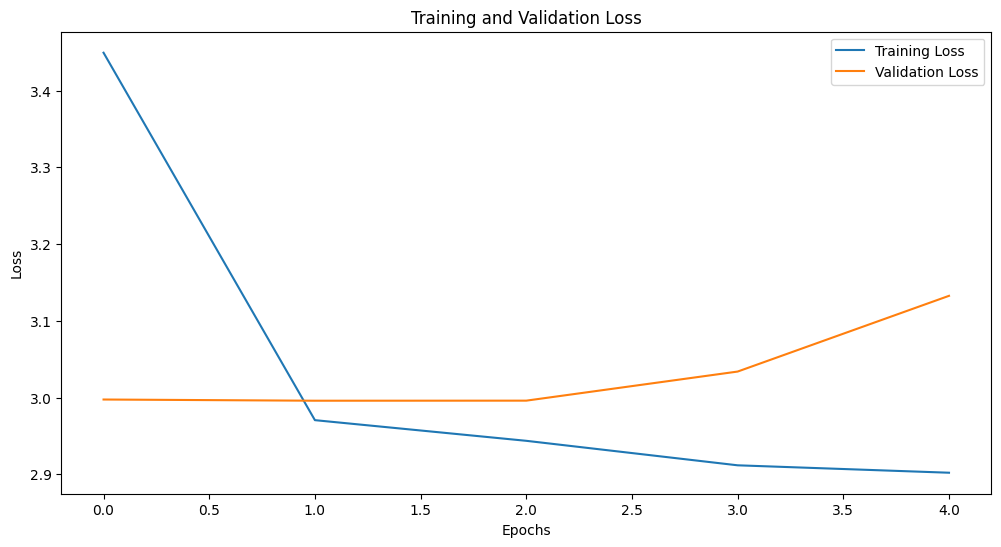

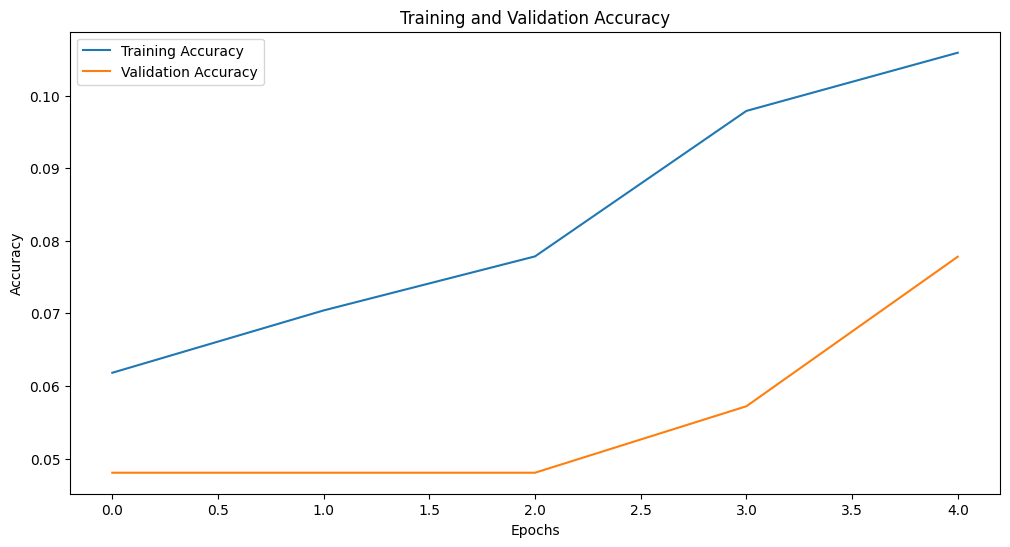

In [16]:
resnet_model = build_resnet_model()

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1)

predictions = resnet_model.predict(X_test)
log_loss_score = log_loss(y_test, predictions)
print(f"ResNet Log Loss: {log_loss_score}")

# Plot 
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The results show that the ResNet model struggles to improve significantly during training, with both training and validation accuracy remaining low and validation loss not decreasing consistently over the epochs. Despite slight improvements in training accuracy and loss, the validation log loss of 2.996 suggests that the model is not effectively learning to generalize to the validation data, indicating potential issues with model capacity, data preprocessing, or the dataset itself.

### GoogleNet Model


This function builds a GoogleNet (InceptionV3) model without pretrained weights, adds custom classification layers for the top 20 breeds, and compiles it with the Adam optimizer and categorical cross-entropy loss for training.


In [17]:
def build_googlenet_model():
    # Initialize InceptionV3 without pretrained weights
    base_model = InceptionV3(weights=None, include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = True  # Allow training on all layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(len(top_20_breeds), activation='softmax')])
    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### GoogleNet training and validation

In this code, I train a GoogleNet (InceptionV3) model on the training data (X_train, y_train) with early stopping to monitor the validation loss (val_loss) and prevent overfitting, stopping training if the validation loss does not improve for 5 consecutive epochs. The model is trained for a maximum of 5 epochs using a batch size of 32, and its performance is evaluated on the test data (X_test, y_test) by calculating the log loss. After training, I visualize the training and validation loss and accuracy trends over epochs to analyze the model’s learning progress and convergence. These visualizations help assess the model’s performance and identify potential issues like overfitting or underfitting.

Epoch 1/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.0715 - loss: 3.2141 - val_accuracy: 0.0572 - val_loss: 3.0345
Epoch 2/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.1138 - loss: 2.8691 - val_accuracy: 0.0526 - val_loss: 3.1968
Epoch 3/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.1617 - loss: 2.7102 - val_accuracy: 0.0503 - val_loss: 4.5340
Epoch 4/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.1897 - loss: 2.5798 - val_accuracy: 0.0526 - val_loss: 3.0589
Epoch 5/5
55/55 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.1577 - loss: 2.6786 - val_accuracy: 0.0503 - val_loss: 5.5445
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 614ms/step
GoogleNet Log Loss: 3.0345116123034686


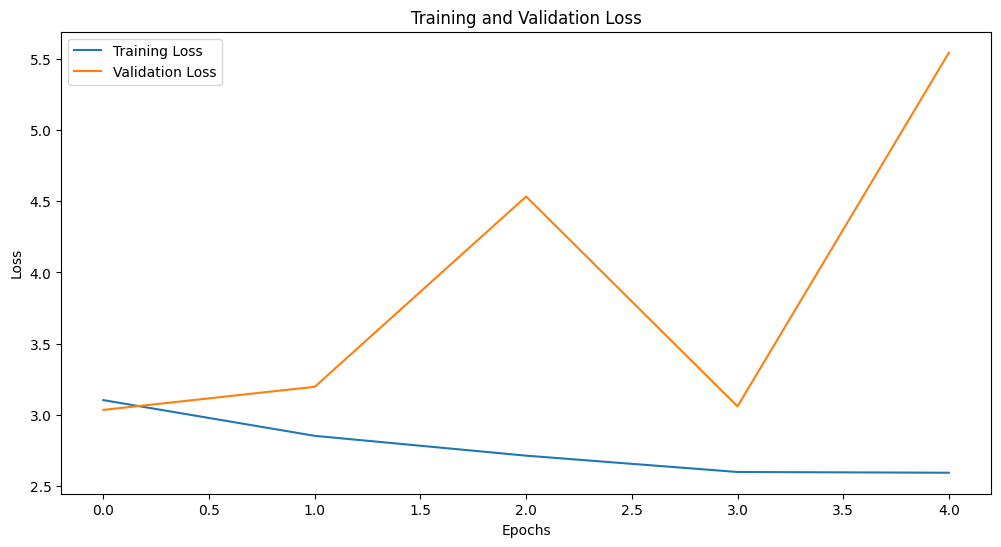

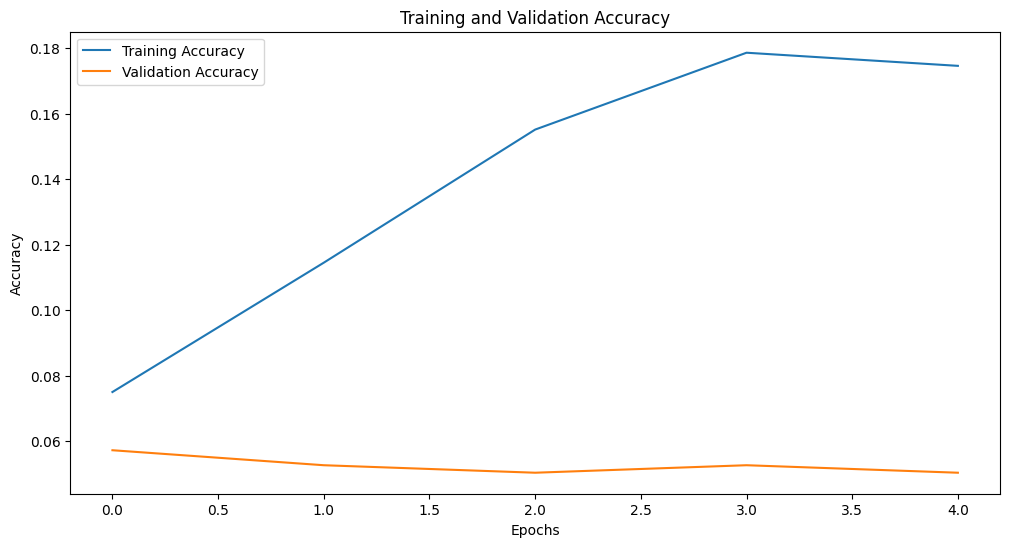

In [19]:
# Build and train the model
googlenet_model = build_googlenet_model()

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = googlenet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1)

# Evaluate the model
from sklearn.metrics import log_loss
predictions = googlenet_model.predict(X_test)
log_loss_score = log_loss(y_test, predictions)
print(f"GoogleNet Log Loss: {log_loss_score}")

# Plot 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



The results show that the GoogleNet model struggled to learn, with training accuracy improving slightly to 15.77% but validation accuracy remaining very low (around 5%). The increasing validation loss and final log loss of 3.0345 indicate poor generalization and potential overfitting, suggesting issues like insufficient data or task complexity

### Conclusion

Neither model performed well, but ResNet slightly outperformed GoogleNet with a lower log loss (2.996 vs. 3.0345) and marginally better validation accuracy. Both models struggled with low generalization and task complexity, indicating a need for improved preprocessing, more data, or hyperparameter tuning.

To improve the model performance, I could experiment with data augmentation techniques to artificially increase the dataset size and introduce variability, potentially improving generalization. Using pretrained weights (e.g., imagenet) for transfer learning could help leverage existing knowledge and boost accuracy. Hyperparameter tuning, such as adjusting learning rates, batch sizes, or optimizer settings, may also enhance results. Additionally, simpler architectures like MobileNet or EfficientNet could be explored for faster training and better performance on limited data, while fine-tuning the last few layers of a pretrained model could provide a more task-specific representation. Finally, ensuring balanced classes and employing cross-validation could improve robustness and help identify overfitting or underfitting issues.